# Text CNN
2020-2 Artifitial Intelligence week10 assignment.   
Text CNN + POS data.   
updated 1108.   

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


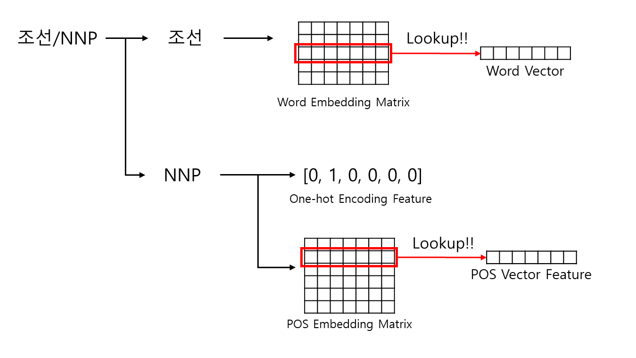

In [70]:
from IPython.display import Image
import os
root_dir = "/content/drive/My Drive/AI_assignment/TextCNN"
Image(os.path.join(root_dir, "homework.PNG"))

# step1) TextCNN model 생성

In [160]:
# ready
import torch
import torch.nn as nn
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torch.optim as optim

import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# model
class TextCNN(nn.Module):
    def __init__(self, config):
        # 항상 torch.nn.Module 을 상속받고 시작
        super(TextCNN, self).__init__()
        # setting config 
        self.word_vocab_size = config["word_vocab_size"]
        self.embedding_size = config["embedding_size"]
        self.max_length = config["max_length"]
        self.num_labels = config["num_labels"]
        self._activation = nn.ReLU()
        self.num_filters = config["num_filters"]      # 100
        self.ohe = OneHotEncoder()
        self.embedding = nn.Embedding(num_embeddings=self.word_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)     # 고정길이로 만들어주기 위한 패딩
        
        self.conv_layer = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_size,
                                                           out_channels=self.num_filters,
                                                           kernel_size=int(n_gram)) for n_gram
                                                 in config["filter_size"]])

        self.fc_layer = nn.Linear(in_features=self.num_filters*len(config["filter_size"]), out_features=self.num_labels)

    def forward(self, input_features, input_poses, labels=None):
        
        lookup_input_features = self.embedding(input_features).permute(0,2,1)      # lookup feature 를 여기서 짜서 개복잡함
        
        if config['pos_mode'] == 'lookup':     

            lookup_input_poses = self.embedding(input_poses)#.permute(0,2,1) 
            
            filter_outputs_pos = []
            for i in range(len(self.conv_layer)):
                # conv + max pooling
                conv_output = self.conv_layer[i](lookup_input_poses)#.permute(0, 2, 1).max(dim=1)[0]        
                activated_output = self._activation(conv_output)
                filter_outputs_pos.append(activated_output)

        else:
            filter_outputs_pos = self.ohe(input_poses)

        filter_outputs = []
        for i in range(len(self.conv_layer)):
            # conv + max pooling
            conv_output = self.conv_layer[i](lookup_input_features).permute(0, 2, 1).max(dim=1)[0]        
            activated_output = self._activation(conv_output)
            filter_outputs.append(activated_output)

        ## feature 추가
        maxpool_pos = torch.cat(tensors=filter_outputs_pos, dim=-1)
        maxpool_output = torch.cat(tensors=filter_outputs, dim=-1)
        concat_ouput = torch.cat([maxpool_pos, maxpool_output], dim=1)

        # maxpool_output : [batch, 3*num_filters]
        logits = self.fc_layer(concat_ouput)

        
        if labels is not None:
            loss_fnc = nn.CrossEntropyLoss()
            loss = loss_fnc(logits, labels)     # 2차원,1차원
            return loss
        else:
            output = torch.argmax(logits, -1)
            return output


# step2) Load data 
load_vocab으로 pos_vocab.txt 파일도 불러들여서 단어사전 생성해준다.  
word 처럼 pos에 대한 정보도 따로 저장해둔다.     
```
# 추가된 코드
pos2idx, idx2pos = load_vocab(config['pos_vocab_file'])
word = [w for w in question.strip().split(' ')]
pos = ' '.join([p.strip().split('/')[1] for p in word])
# pos to tensor
indexing_pos = convert_data2feature(pos, pos2idx) -> data2feature 함수 사용 후 tensor변환
```

In [161]:
from tqdm import tqdm

def load_vocab(f_name):
    vocab_file = open(os.path.join(root_dir, f_name),'r',encoding='utf8')
    print("{} vocab file loading...".format(f_name))

    symbol2idx, idx2symbol = {"<PAD>":0, "<UNK>":1}, {0:"<PAD>", 1:"<UNK>"}

    index = len(symbol2idx)
    for line in tqdm(vocab_file.readlines()):
        symbol = line.strip()
        symbol2idx[symbol] = index
        idx2symbol[index]= symbol
        index+=1

    return symbol2idx, idx2symbol


def convert_data2feature(data, symbol2idx, max_length=None):

    if max_length:
        # 고정 길이의 0 벡터 생성
        feature = np.zeros(shape=(max_length), dtype=np.int)
        words = data.split()

        for idx, word in enumerate(words[:max_length]):
            if word in symbol2idx.keys():
                feature[idx] = symbol2idx[word]
            else:
                feature[idx] = symbol2idx["<UNK>"]
            #~~~~~~
        return feature

    else:
        return symbol2idx[data] if data in symbol2idx.keys() else symbol2idx["<UNK>"]

# 파라미터로 입력받은 파일로부터 tensor객체 생성
def load_data(comfig, f_name):
    file = open(os.path.join(root_dir, f_name),'r',encoding='utf8')

    word2idx, idx2word = load_vocab(config["word_vocab_file"])
    label2idx, idx2label = load_vocab(config["label_vocab_file"])
    pos2idx, idx2pos = load_vocab(config['pos_vocab_file'])

    indexing_questions, indexing_labels, indexing_poses = [], [], []

    print("{} file loading...".format(f_name))
    for line in tqdm(file.readlines()):
        question, label = line.strip().split('\t')

        word = [w for w in question.strip().split(' ')]
        pos = ' '.join([p.strip().split('/')[1] for p in word])

        indexing_question = convert_data2feature(question, word2idx, config["max_length"])
        indexing_label = convert_data2feature(label, label2idx)
        indexing_pos = convert_data2feature(pos, pos2idx)

        indexing_questions.append(indexing_question)
        indexing_labels.append(indexing_label)
        indexing_poses.append(indexing_pos)

    indexing_questions = torch.tensor(indexing_questions, dtype=torch.long)
    indexing_labels = torch.tensor(indexing_labels, dtype=torch.long)
    indexing_poses = torch.tensor(indexing_poses, dtype=torch.long)

    return indexing_questions, indexing_labels, indexing_poses

# tensor 객체를 리스트 형으로 바꾸기 위한 함수
def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()


# step3) train & evaluation

In [167]:
def train(config):
    model = TextCNN(config).cuda()

    # 데이터 Load
    train_input_features, train_labels, train_input_poses = load_data(config, config["train_file"])
    test_input_features, test_labels, test_input_poses = load_data(config, config["test_file"])

    # 불러온 데이터를 TensorDataset 객체로 변환
    train_features = TensorDataset(train_input_features, train_labels)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    test_features = TensorDataset(test_input_features, test_labels)
    test_dataloader = DataLoader(test_features, shuffle=True, batch_size=config["batch_size"])

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    for epoch in range(config["epoch"]):
        losses = []
        for step, batch in enumerate(train_dataloader):
            # .cuda()를 이용하여 메모리에 업로드,  배치마다 쿠다에 올리네...
            batch = tuple(t.cuda() for t in batch)
            input_features, labels = batch
            input_poses = train_input_poses.cuda()

            loss = model([input_features, input_poses], labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (step + 1) % 100 == 0:
                print("{} step processed.. current loss : {}".format(step + 1, loss.data.item()))
            losses.append(loss.data.item())

        print("Average Loss : {}".format(np.mean(losses)))
        
        # 모델 저장
        torch.save(model.state_dict(), os.path.join(config["output_dir_path"], "epoch_{}.pt".format(epoch + 1)))

        do_test(model, test_dataloader)


def test(config):
    model = TextCNN(config).cuda()
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))
    test_input_features, test_labels = load_data(config, config["test_file"])

    test_features = TensorDataset(test_input_features, test_labels)
    test_dataloader = DataLoader(test_features, shuffle=True, batch_size=config["batch_size"])

    do_test(model, test_dataloader)

def do_test(model, test_dataloader):
    model.eval()
    predicts, answers = [], []
    for step, batch in enumerate(test_dataloader):
        # .cuda() 함수를 이용하요 메모리에 업로드
        batch = tuple(t.cuda() for t in batch)

        input_features, labels = batch
        output = model(input_features)

        predicts.extend(tensor2list(output))
        answers.extend(tensor2list(labels))
    # 성능 평가
    print("Accuracy : {}".format(accuracy_score(answers, predicts)))

## main

In [168]:
if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "train",
              'pos_mode':'lookup',     # 추가
              "train_file":"train.txt",
              "test_file": "test.txt",
              "word_vocab_file":"vocab.txt",
              'pos_vocab_file' : 'pos_vocab.txt',    # 추가
              "label_vocab_file": "label_vocab.txt",
              "trained_model_name":"epoch_{}.pt".format(5),
              "output_dir_path":output_dir,
              "word_vocab_size":16385,
              "num_labels": 12,
              "filter_size":[2, 3, 4],
              "num_filters":100,
              "embedding_size":200,
              "max_length": 50,
              "batch_size":32,
              "epoch":5,
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

100%|██████████| 9000/9000 [00:00<00:00, 66730.66it/s]

vocab.txt vocab file loading...
label_vocab.txt vocab file loading...
pos_vocab.txt vocab file loading...
train.txt file loading...



100%|██████████| 1000/1000 [00:00<00:00, 64607.27it/s]

vocab.txt vocab file loading...
label_vocab.txt vocab file loading...
pos_vocab.txt vocab file loading...
test.txt file loading...


TypeError: ignored

# comment
모델 작성 및 데이터 로드는 고쳤지만, dataloader를 통해 셔플 후 배치 사이즈로 넣어주는 부분에서 multiple input 이 구현되지 않아서 작동하지 않습니다.   
정답 코드부탁드립니다.  